> # Reflection

# Prerequisite Blocks for the code to Run

In [1]:
import numpy as np
import pandas as pd
import matplotlib   # Change this to a more specific import for graphs
import matplotlib.pyplot as plt


In [2]:
def analyze(P, I, D):
    %matplotlib inline 
    with open("data_{}_{}_{}".format(P, I, D)) as data_file:
        # read off two lines of "junk"
        data_file.readline()
        data_file.readline()

        # for all subsequent lines, the first line is the input data, the second line is the control data
        # Only the first line is relevant

        lines = data_file.readlines()
        
    driving_data = []
    for i, line in enumerate(lines):
        if i % 2 == 0:
            splited_line = [ l.strip() for l in line[4:].split("Steering Value:")]
            # if this is not the last line ( which is a system exit message)
            if(len(splited_line)) != 1:
                driving_data.append({
                    "CTE" : float(splited_line[0]),
                    "steering_angle" : float(splited_line[1])
                })
    df = pd.DataFrame(driving_data)
    print("P = {}, I = {}, D = {}".format(P, I, D))
    f, (ax1, ax2) = plt.subplots(2, 1)
    df = df.groupby(df.index // 50).mean()[10:]
    ax1.plot(df["CTE"])
    ax1.set_title("CTE")
    ax2.plot(df["steering_angle"])
    ax2.set_title("steering_angle")
    ax2.set_ylim((-0.25, 0.25))
    


    

# Reflection

## Introduction of Dataset and General Observations
- The data is collected by recording the output message from my C++ PID Controller code
- The version of the simulator is v1.45, which should be the newest version as of Nov 28, 2017
- I did not calculate the framerate for the simulator. I used the (frame index / 50) as the time unit for analysis. In general, the X-axis of all the plots in this document are irrelevant
- The track has a major left turns at t=100, 220 and 320. There is one major right turn right after the second left turn
- The CTE data on the bridge might not be correct, especically at the end of the bridge

## How I tune the hyperparameters
- First, I tune the hyperparameters manually. During this process, I study the effect of each parameter (P, I, D)
- Then I implement a twiddle algorithm to set the hyperparameters automatically and dynamically. 
- There is not a defined final value of hyperparameter because of the constant change of the curvature. I will just let my twiddle algorithm to set the value of hyperparameters automatically in order to accomodate the curvature of the track
- However, there is a final hyperparameter that works without twiddling: P = 0.292378, I = 0.001, D = 30

## How each parameter influence PID controller
- This section also describes my first step of hyperparameter tuning
- I tuned the parameter started from P, then I tuned D, finally I tuned I
- The car is driven at 10mph during manual tuning

### The Effect of P
- Assume P is not a negative number
- Small P: The CTE does not converge to 0 or any given point quickly, which causes trouble when the car is turning
- Large P: The steering angle is too sensitive to the value of CTE, which causes a very poor passenger experience. There is a lot of sudden turning regardless of the road curvature which might causes motion sickness.

### My first attempt on hyperparameters

P = 5, I = 0, D = 30


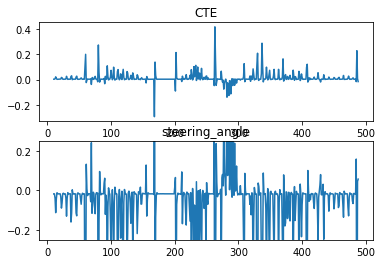

In [4]:
# The number is chosen arbitrarily without any reasoning
# The car is on the track all the time
analyze(5, 0, 30)

P = 0.5, I = 0, D = 30


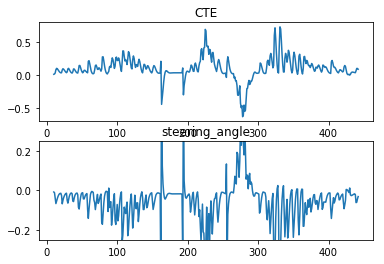

In [116]:
# The car is on the track all the time
analyze(0.5, 0, 30)

P = 0.05, I = 0, D = 30


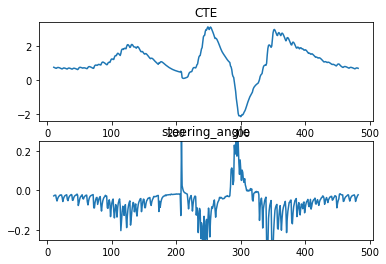

In [115]:
# The car is on the track all the time, even the CTE is way larger
%matplotlib inline 
analyze(0.05, 0, 30)

As P increases, CTE has more time staying around 0, but it still wiggles around 0. As P increases, the steering angle becomes more and more volatile even if the car is driving mostly straight, and it changes in a large interval. Therefore, although incresing P will help make the car stay on track, but it will cause a very poor passenger experience.

### The Effect of D
- Assume D is not a negative number
- Small D: The car could not adapt to the change of CTE, which makes the car drives off the road when turning, especially when P is also small.
- Large D: The car is oversensitive to the change of CTE, and there are a lot of unnessesary change of steering angle, which will cause a significant decrease of life expectancy of the car


P = 0.05, I = 0, D = 3


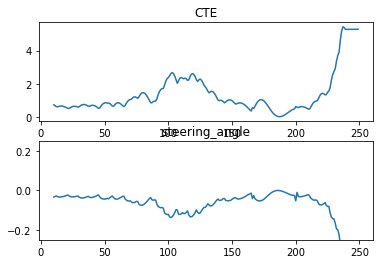

In [5]:
# The car crashed halfway
analyze(0.05, 0, 3)

P = 0.05, I = 0, D = 30


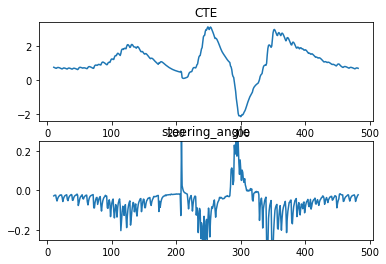

In [119]:
analyze(0.05, 0, 30)

P = 0.05, I = 0, D = 300


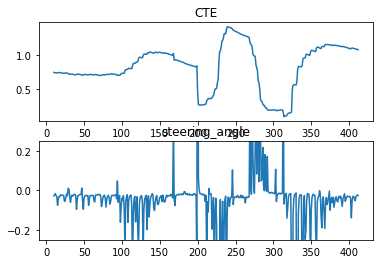

In [6]:
# The car drives safely, but a lot of unnessesary change of steering angle
analyze(0.05, 0, 300)

Because the wiggling at P = 0.5 and above is unacceptable for passengers, I will use P = 0.05 to analyze the effect of D.

When D = 3, the car could not correct its path to the center of the track enough to successfully drive a full lap, it crashes at the second left-turn. 

As D increases, the car is more able to make the correction and stay relatively close to 0, and it starts to drive more toward the center of the track. However, as D increases, the steering angle becomes more and more volatile, but the change is not that large to cause motion sickness. However, the high frequency of change in steering angle could cause a much faster machine abrasion, which shortens the life expectancy of the car.

In addition, when D is high enough, the car would not converge to 0, but converge to another value instead. Although this prevents the car from driving outside the track, it also precludes the car from maintaing a given position on the track, which would also cause safety problems.

### The Effect of I
- Small I: It will correct the internal error of the car. Also stablize the car while turning without using too much steering compared to larger D.
- Large I: Increasing wiggling of CTE. Increasing change of turning angle. Until the CTE is too large to drive safely.



P = 0.05, I = 0, D = 30


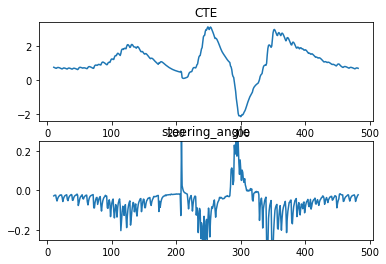

In [10]:
analyze(0.05, 0, 30)

P = 0.05, I = 0.001, D = 30


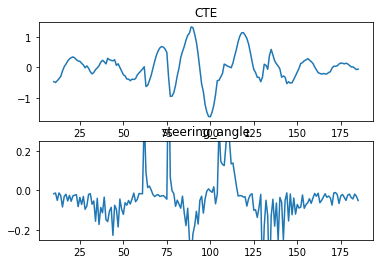

In [7]:
# This drives the car safely with a lower CTE without more steering
analyze(0.05, 0.001, 30)

P = 0.05, I = 0.01, D = 30


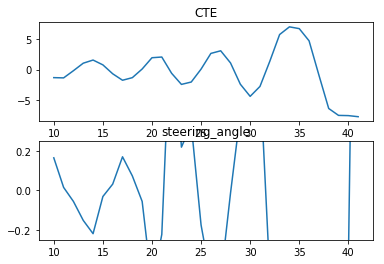

In [8]:
# This is another failed example
analyze(0.05, 0.01, 30)

## Step 2: Dynamic Twiddling
- After experimenting the effect of each hyperparameter, I decided to use P = 0.05, I = 0.001, D = 30 as the starting point for twiddling
- I used a method similar to the lesson on PID for twiddling, except I am not resetting the car each time after twiddling because it is impossible using the simulator.
- The paramters are twiddled every 50 updates from PID using the sum of CTE of the past 50 updates. There is no termination point of twiddling.
- I tried twiddling all 3 parameters and just twiddle P solely, and I found twiddling P only works better
- Before twiddling, the car could drive at 10mph safely, but it cannot drive at more than 30mph safely
- After twidding, the car could drive at 35mph safely for most of the times according to the rubric. The car could drive at 50mph without crashing, but it will pop onto the ledges.
- "Final" parameters when the car finished 1 lap at 35mph: P = 0.292378, I = 0.001, D = 30

## Further Experiments
- I also tried to use  P = 0.292378, I = 0.001, D = 30 without dynamic twiddling. The car can drive safely at 35mph all the times, but the car is much shakier.
- Using P = 0.05, I = 0.001, D = 30 with dynamic twiddling on P does not grarantee a safety drive at 35mph, but it drives safely for most of the times.